In [1]:
sys.path.append('../')
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import sqlalchemy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from RtdRay import RtdRay
from mpl_toolkits.basemap import Basemap
from helpers import StationPhillip

rtd = RtdRay(notebook=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
r = np.random.randint(5,25, size=100)

class BubbleChart:
    def __init__(self, r):
        self.n = len(r)
        self.bubbles = np.ones((self.n, 3))
        self.bubbles[:, 2] = r
        self.maxstep = 2 * self.bubbles[:,2].max()
        length = np.ceil(np.sqrt(self.n))
        grid = np.arange(0, length * self.maxstep, self.maxstep)
        gx,gy = np.meshgrid(grid, grid)
        self.bubbles[:,0] = gx.flatten()[:self.n]
        self.bubbles[:,1] = gy.flatten()[:self.n]
        self.bubbles[:,:2] = self.bubbles[:,:2] - np.mean(self.bubbles[:,:2], axis=0)
        self.com = self.center_of_mass()
        self.moves = 0
    
    def center_of_mass(self):
        return np.average(self.bubbles[:,:2], axis=0, weights=self.bubbles[:,2]) # + np.random.random_sample(2) * self.maxstep**2

    def distance(self, bubble, bubbles):
        center_distance = np.sqrt(np.power(bubble[0] - bubbles[:, 0], 2)
                                  + np.power(bubble[1] - bubbles[:, 1], 2))
        return center_distance - bubble[2] - bubbles[:, 2]

    def check_collisions(self, bubble, bubbles):
        distance = self.distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collapse(self):
        step_dist = self.maxstep
        for itteration in range(1,100):
            moves = 0
            for i in range(self.n):
                # calculate position closer to the com
                # step_dist = self.maxstep / (itteration / 2)
                dir_vec = self.com - self.bubbles[i, :2]
                # if i / 2:
                #     dir_vec += np.random.random_sample(2) / 0.001
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                new_point = self.bubbles[i, :2] + dir_vec * step_dist
                # check if it collides
                new_bubble = np.append(new_point, self.bubbles[i, 2])
                if not self.check_collisions(new_bubble, np.delete(self.bubbles, i, 0)):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    self.com += (np.random.random_sample(2) - 0.5) * step_dist**2
                    moves += 1
                    self.moves += 1
            if moves / self.n < 0.3:
                step_dist /= 2
                print(step_dist)

    def plot(self, ax):
        for i in range(self.n):
            circ = plt.Circle(self.bubbles[i,:2], self.bubbles[i,2])
            ax.add_patch(circ)

### per station analysis

In [13]:
class PerStationAnalysis(StationPhillip):
    def __init__(self, rtd_df):
        super().__init__(notebook=True)
        self.data = rtd_df.groupby('station')

    def get_trips_per_station(self):
        self.trips_per_station = self.data['station'].value_counts().compute()

    def plot(self):
        left = 5.67
        right = 15.64
        bot = 47.06
        top = 55.06
        plt.figure(figsize=(180/2,100/2))
        m = Basemap(llcrnrlon=left,llcrnrlat=bot,urcrnrlon=right,urcrnrlat=top,
                    resolution='i', projection='tmerc', lat_0 = 51, lon_0 = 10)
        m.drawcoastlines(linewidth=0.72, color='black')
        m.drawcountries(zorder=0, color='black')

        for station in self.trips_per_station.index:
            station = station[0]
            x, y = m(*self.get_location(name=station))
            m.scatter(x, y, color='green', s=self.trips_per_station[station], alpha=0.1)

In [3]:
rtd_df = rtd.load_data(columns=['station', 'c'])

In [14]:
per_station = PerStationAnalysis(rtd_df)

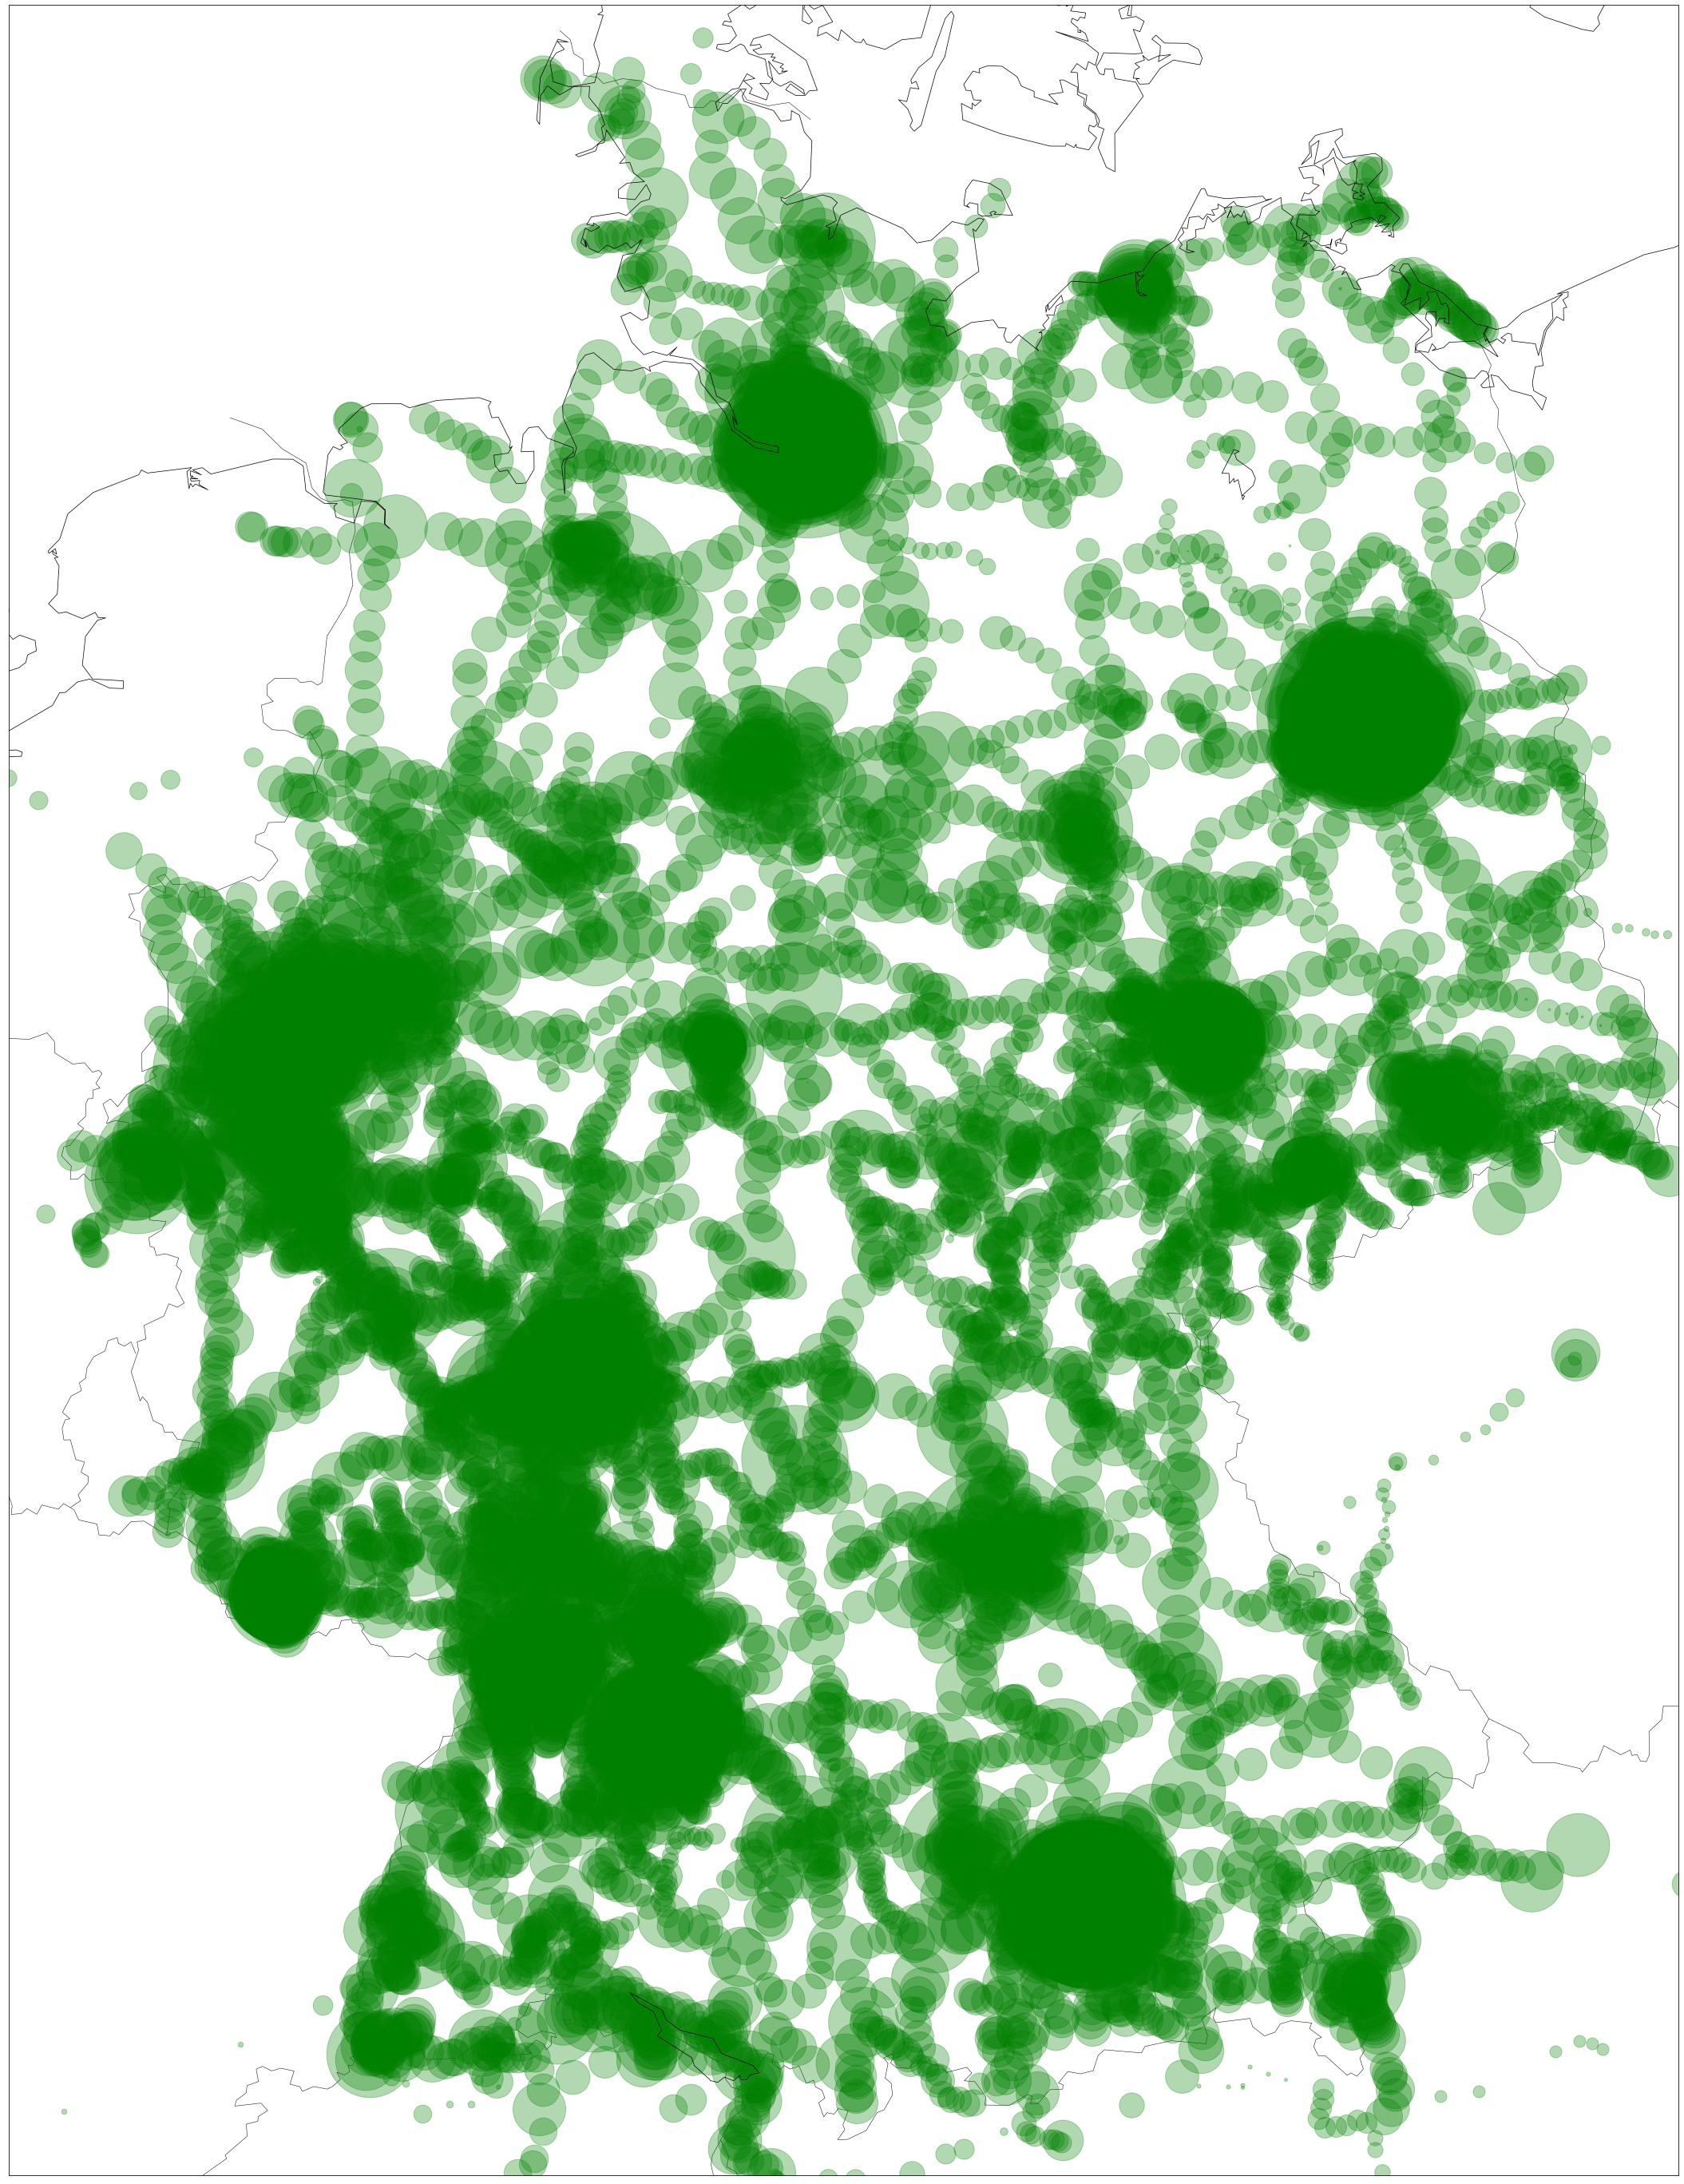

In [12]:
per_station.get_trips_per_station()
per_station.plot()
plt.show()

### train type stuff

In [ ]:
def train_types_bubble_chart(rtd_df):
    train_types = rtd_df['c']
    per_train_type = train_types.value_counts()
    per_train_type = np.sqrt(per_train_type.to_numpy() / np.pi)
    print(per_train_type)
    bubble_plot = BubbleChart(per_train_type)

    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    ax.axis("off")

    bubble_plot.collapse()

    bubble_plot.plot(ax)
    ax.relim()
    ax.autoscale_view()
    plt.show()

In [ ]:
def train_types_pie_chart(rtd_df):
    train_types = rtd_df['c']
    per_train_type = train_types.value_counts()
    per_train_type
    per_train_type.plot.pie(figsize=(30, 30))

### other

In [ ]:
def data_over_time(rtd_df):
    rtd_df['arr'].plot()

In [ ]:
def trains_per_station_map_bubble_plot(rtd_df):
    trains_per_station = rtd_df['station'].value_counts()


In [ ]:
def delay_over_time(delays):
    delays['arr_delay'] = delays['arr_changed_time'] - delays['arr']
    delays['arr_unix'] = delays['arr'] / 60
    delays['arr'] = dd.to_datetime(delays['arr'] - delays['arr'] % (60 * 60 * 24), unit='s')
    delays = delays.groupby('arr').agg({'arr_unix':['std'], 'arr_delay': ['mean', 'std', 'max', 'min']})
    with ProgressBar():
        return delays.compute()

In [ ]:
train_types = rtd.load_data(columns=['c']).compute()
train_types_pie_chart(train_types)

In [ ]:
train_types_pie_chart(train_types)

In [ ]:
train_types_bubble_chart(train_types)

In [ ]:
rtd = RtdRay(notebook=True)
delays = rtd.load_data(columns=['arr', 'arr_changed_time'])
grouped_by = delay_over_time(delays)

In [ ]:
plot = grouped_by.reset_index().plot.scatter(y=('arr_delay', 'max'), x=('arr'))

In [ ]:
grouped_by.reset_index()

In [ ]:
rtd.load_data(columns=['arr', 'arr_changed_time'])['arr_changed_time'].head()

In [ ]:
delays = rtd.load_data(columns=['arr', 'arr_changed_time', 'arr_changed_platform', 'arr_changed_status', 'stay_time'])
delays_df = delays.compute()
delays_df['arr_changed_time'] - delays_df['arr']

In [ ]:
rtd['ar_pt'] = rtd['ar_pt'].astype('Int64').astype('str')
rtd['ar_ct'] = rtd['ar_ct'].astype('Int64').astype('str')

In [ ]:
rtd['ar_pt'] = pd.to_datetime(rtd['ar_pt'], format='%y%m%d%H%M', errors='coerce')

In [ ]:
rtd['ar_ct'] = pd.to_datetime(rtd['ar_ct'], format='%y%m%d%H%M', errors='coerce')

In [ ]:
rtd['ar_delay'] = rtd['ar_ct'] - rtd['ar_pt']